In [2]:
# Importing modules
from numba import jit, vectorize, boolean, complex128
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing as mp
%matplotlib inline

# Naive implementation

In [3]:
# Creating grid
def make_grid(p_re, p_im):
    '''
    Creates a 2D array of complex numbers given a resolution parameters.
    :p_re: Resolution of the Real component of the grid
    :p_im: Resolution of the Imaginary component of the grid
    '''
    real = np.linspace(-2, 1, p_re)
    imag = np.linspace(-1.5, 1.5, p_im)
    grid_real, grid_imag = np.meshgrid(real, imag)
    return grid_real + grid_imag * 1j

# Check if the point is in Mandelbrot set
def isMandelbrot(c, maxIter, z=0, T=2):
    '''
    Checks if a complex number is in Mandelbrot set.
    :c: Comlex number
    :maxIter: Maximum iteration number to check for
    :z: (default:0) Starting point of calculation
    :T: (default:2) Threshold for determining if the point is in set
    '''
    for step in range(maxIter):
        z = z*z + c
        if abs(z) > T:
            return step
    return 0


In [13]:
# Compute Mandelbrot set
def Mandelbrot_set_naive(grid):
    '''
    Makes a Mandelbrot set.
    :grid: 2D array of complex numbers derived from make_grid() function
    '''
    result_grid = np.zeros(grid.shape)
    for i, row in enumerate(grid):
        for j, col in enumerate(grid):
            result_grid[i][j] = isMandelbrot(grid[i][j], 100) 
    return result_grid


---

# Visual confirmation that the code does what it should.

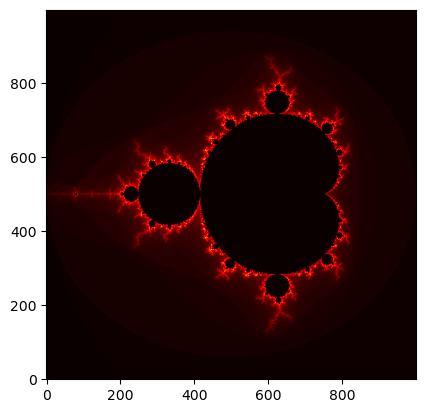

In [5]:

# Create Mandelbrot image helper function
def create_image(p_re, p_im, cmap='hot'):
    '''
    Make an image out of Mandelbrot set.
    :p_re: Resolution of the Real component of the grid
    :p_im: Resolution of the Imaginary component of the grid
    '''
    grid = make_grid(p_re, p_im)
    result_grid = Mandelbrot_set_naive(grid)
    plt.imshow(result_grid, cmap=cmap, origin='lower')

create_image(1000,1000)


---

In [90]:
grid = make_grid(3000,3000)
%timeit Mandelbrot_set_naive(grid)

22.1 s ± 257 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


**NAIVE:** 22.1 s ± 257 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

---

# Vectorized implementation

In [4]:
# Compute Mandelbrot set
def Mandelbrot_set_vectorized(grid):
    '''
    Makes a Mandelbrot set.
    :grid: 2D array of complex numbers derived from make_grid() function
    '''
    result_grid = np.zeros(grid.shape)
    vectorized_isMandelbrot = np.vectorize(isMandelbrot)
    result_grid = vectorized_isMandelbrot(grid, 100) 
    return result_grid

In [94]:
grid = make_grid(3000,3000)
%timeit Mandelbrot_set_vectorized(grid)

13.7 s ± 106 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


**Vectorized:** 13.7 s ± 106 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

---

# Numba-naive implementation

In [3]:
# Creating grid
def make_grid(p_re, p_im):
    '''
    Creates a 2D array of complex numbers given a resolution parameters.
    :p_re: Resolution of the Real component of the grid
    :p_im: Resolution of the Imaginary component of the grid
    '''
    real = np.linspace(-2, 1, p_re)
    imag = np.linspace(-1.5, 1.5, p_im)
    grid_real, grid_imag = np.meshgrid(real, imag)
    return grid_real + grid_imag * 1j


# Check if the point is in Mandelbrot set
@jit(nopython=True)
def isMandelbrot(c, maxIter, z=0, T=2):
    '''
    Checks if a complex number is in Mandelbrot set.
    :c: Comlex number
    :maxIter: Maximum iteration number to check for
    :z: (default:0) Starting point of calculation
    :T: (default:2) Threshold for determining if the point is in set
    '''
    for step in range(maxIter):
        z = z*z + c
        if abs(z) > T:
            return step
    return 0


In [4]:
# Compute Mandelbrot set
@jit(nopython=True)
def Mandelbrot_set_naive(grid):
    '''
    Makes a Mandelbrot set.
    :grid: 2D array of complex numbers derived from make_grid() function
    '''
    result_grid = np.zeros(grid.shape)
    for i, row in enumerate(grid):
        for j, col in enumerate(grid):
            result_grid[i][j] = isMandelbrot(grid[i][j], 100) 
    return result_grid


In [15]:
grid = make_grid(3000,3000)
%timeit Mandelbrot_set_naive(grid)

1.15 s ± 34.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


**Numba-Naive:** 1.15 s ± 34.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

---

# Vectorized Multiprocessing implementation

In [9]:
M = mp.cpu_count()
pool = mp.Pool(M)

In [10]:
grid = make_grid(3000,3000)
%timeit pool.map_async(Mandelbrot_set_vectorized, grid).get()

1.51 s ± 18.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


**Multiprocessing-Vectorized:** 1.51 s ± 18.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

---

# Numba-naive optimized implementation

In [3]:
# Creating grid
def make_grid(p_re, p_im):
    '''
    Creates a 2D array of complex numbers given a resolution parameters.
    :p_re: Resolution of the Real component of the grid
    :p_im: Resolution of the Imaginary component of the grid
    '''
    real = np.linspace(-2, 1, p_re)
    imag = np.linspace(-1.5, 1.5, p_im)
    grid_real, grid_imag = np.meshgrid(real, imag)
    return grid_real + grid_imag * 1j


# Vectorized helper for in or out of threshold calculation
@vectorize([boolean(complex128)])
def notInSet(z):
    return (z.real*z.real + z.imag*z.imag) < 2.0


# Vectorized helper for z calculation
@vectorize([complex128(complex128, complex128)])
def zCalc(z,c):
    return z*z + c 


# Check if the point is in Mandelbrot set
@jit(nopython=True)
def isMandelbrot(c, maxIter, z=0):
    '''
    Checks if a complex number is in Mandelbrot set.
    :c: Comlex number
    :maxIter: Maximum iteration number to check for
    :z: (default:0) Starting point of calculation
    :T: (default:2) Threshold for determining if the point is in set
    '''
    for step in range(maxIter):
        z = zCalc(z,c)
        if notInSet(z):
            return step
    return 0


In [4]:
# Compute Mandelbrot set
@jit(nopython=True)
def Mandelbrot_set_naive(grid):
    '''
    Makes a Mandelbrot set.
    :grid: 2D array of complex numbers derived from make_grid() function
    '''
    result_grid = np.zeros(grid.shape, np.int8)
    for i in range(grid.shape[0]):
        for j in range(grid.shape[1]):
            result_grid[i][j] = isMandelbrot(grid[i][j], 100) 
    return result_grid

In [8]:
grid = make_grid(3000,3000)
%timeit Mandelbrot_set_naive(grid)

732 ms ± 427 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


**Numba-naive optimized:** 732 ms ± 271 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)

---

# Bonus Guvectorize attempt

In [8]:
# Original code belongs to Jean-François Puget. Below is my tweaked version.

import numpy as np
from numba import jit, vectorize, guvectorize, float64, complex64, int32, boolean


@vectorize([boolean(float64, float64)])
def notInSet(real, imag):
    return (real*real + imag*imag) > 2.0

@jit(int32(complex64, int32))
def mandelbrot(c,maxiter):
    nreal, real, imag = 0, 0, 0
    for n in range(maxiter):
        nreal = real*real - imag*imag + c.real
        imag = 2* real*imag + c.imag
        real = nreal; # Hopefully it is kept in the registere 
        if notInSet(real, imag):
            return n
    return 0

@guvectorize([(complex64[:], int32[:], int32[:])], '(n),()->(n)',target='parallel')
def mandelbrot_numpy(c, maxit, output):
    maxiter = maxit[0]
    for i in range(c.shape[0]):
        output[i] = mandelbrot(c[i],maxiter)
        
def mandelbrot_set2(xmin,xmax,ymin,ymax,width,height,maxiter):
    r1 = np.linspace(xmin, xmax, width, dtype=np.float32)
    r2 = np.linspace(ymin, ymax, height, dtype=np.float32)
    c = r1 + r2[:,None]*1j
    n3 = mandelbrot_numpy(c,maxiter)
    return (r1,r2,n3.T) 

In [9]:
%timeit mandelbrot_set2(-2.0,1,-1.5,1.5,3000,3000,100)

52.5 ms ± 1.43 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


**Guvectorize:** 52.5 ms ± 1.43 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)

---

# Runtime visualization

```
p_re = p_im = 3000
maxIter = 100
T = 2
```

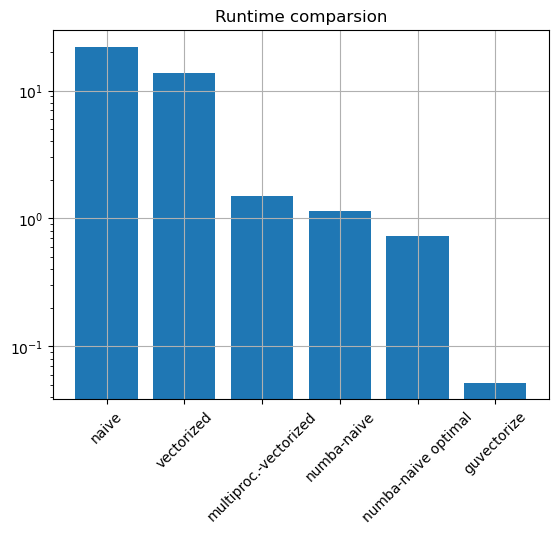

In [3]:
implementations = ["naive", "vectorized", "multiproc.-vectorized", "numba-naive", "numba-naive optimal", "guvectorize"]
runtimes = [22.1, 13.7, 1.51, 1.15, 0.73, 0.052]

plt.bar(implementations, runtimes, log=True)
plt.xticks(rotation=45)
plt.title("Runtime comparsion")
plt.grid()
plt.show()

## **Guvectorize** is x425 times faster than the **Naive** approach! 

Random viz:

[[1.00e+00 6.20e-01 6.83e-02 5.20e-02 3.30e-02 2.35e-03]
 [1.61e+00 1.00e+00 1.10e-01 8.39e-02 5.33e-02 3.80e-03]
 [1.46e+01 9.07e+00 1.00e+00 7.62e-01 4.83e-01 3.44e-02]
 [1.92e+01 1.19e+01 1.31e+00 1.00e+00 6.35e-01 4.52e-02]
 [3.03e+01 1.88e+01 2.07e+00 1.58e+00 1.00e+00 7.12e-02]
 [4.25e+02 2.63e+02 2.90e+01 2.21e+01 1.40e+01 1.00e+00]]

 [[2.35e-03 1.46e-03 1.61e-04 1.22e-04 7.77e-05 5.54e-06]
 [3.80e-03 2.35e-03 2.59e-04 1.98e-04 1.25e-04 8.93e-06]
 [3.44e-02 2.13e-02 2.35e-03 1.79e-03 1.14e-03 8.10e-05]
 [4.52e-02 2.80e-02 3.09e-03 2.35e-03 1.49e-03 1.06e-04]
 [7.12e-02 4.42e-02 4.87e-03 3.71e-03 2.35e-03 1.68e-04]
 [1.00e+00 6.20e-01 6.83e-02 5.20e-02 3.30e-02 2.35e-03]]


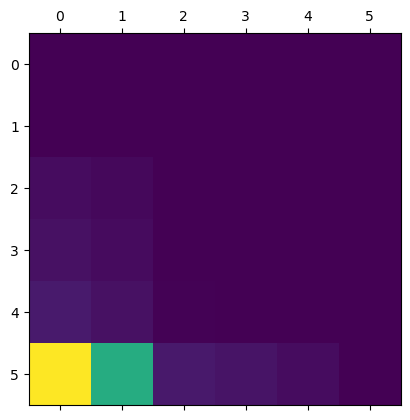

In [28]:
# %timeit -o will return time as object instead of printing it!
# usefull for creating graphs?
np.set_printoptions(precision=2)
runtimes_np = np.array(runtimes)
runtime_matrix = runtimes_np * (1/runtimes_np[:,np.newaxis])
print(runtime_matrix)
normalized_matrix = runtime_matrix / np.max(runtime_matrix)
print("\n",normalized_matrix)
plt.matshow(normalized_matrix)
plt.show()